In [ ]:
# hotel_id = 57b66e62916bb9001839f1d5 , of casino hotel
# Polynomial Regression model

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
import calendar
import pymongo
import urllib.parse
from datetime import date
from pandas import DatetimeIndex
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
import matplotlib.pyplot as plot

In [ ]:
def get_booking_data(hotel_id):
    booking_data = df_bookings[df_bookings.hotel_id == hotel_id]
    booking_data = booking_data[booking_data.cancelled == False]
    booking_data = booking_data.groupby(['stay_dt'],as_index=False)[['rooms']].sum()
    booking_data['stay_dt'] = pd.to_datetime(booking_data['stay_dt'])
    return booking_data

In [ ]:
def initialize(df):
    df['Jan'] = 0 
    df['Feb'] = 0
    df['Mar'] = 0
    df['Apr'] = 0
    df['May'] = 0
    df['Jun'] = 0
    df['Jul'] = 0
    df['Aug'] = 0
    df['Sep'] = 0
    df['Oct'] = 0
    df['Nov'] = 0
    df['Dec'] = 0
    return df

In [ ]:

def format_stay_dt_encode(df):
    df = initialize(df)
    for i in df.index:
        stay_date = df.get_value(i,'stay_dt')
        mm = stay_date.month
        dd = stay_date.day
        yy = stay_date.year
        df.set_value(i,'year',yy)
        df.set_value(i,'day',dd)
        week_day=stay_date.weekday()
        df.set_value(i,'week_day',week_day)
        if(week_day==6 or week_day==5 or week_day==4):
            df.set_value(i,'weekend',1)
        else:
            df.set_value(i,'weekend',0)
            
        if mm == 1:df.set_value(i,'Jan',1)
        elif mm ==2:df.set_value(i,'Feb',1)
        elif mm ==3:df.set_value(i,'Mar',1)
        elif mm ==4:df.set_value(i,'Apr',1)
        elif mm ==5:df.set_value(i,'May',1)
        elif mm ==6:df.set_value(i,'Jun',1)
        elif mm ==7:df.set_value(i,'Jul',1)
        elif mm ==8:df.set_value(i,'Aug',1)
        elif mm ==9:df.set_value(i,'Sep',1)
        elif mm ==10:df.set_value(i,'Oct',1)
        elif mm ==11:df.set_value(i,'Nov',1)
        elif mm ==12:df.set_value(i,'Dec',1)
    df = df[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','week_day','day','weekend','rooms']]
    df = df.groupby(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','week_day','day','weekend'],as_index=False)[['rooms']].mean()
    return df


In [ ]:
def format_stay_dt_test_encode(df):
    df = initialize(df)
    for i in df.index:
        stay_date = df.get_value(i,'stay_dt')
        mm = stay_date.month
        dd = stay_date.day
        df.set_value(i,'day',dd)
        week_day=stay_date.weekday()
        df.set_value(i,'week_day',week_day)
        if(week_day==6 or week_day==5 or week_day==4):
            df.set_value(i,'weekend',1)
        else:
            df.set_value(i,'weekend',0)
        
        if mm == 1:df.set_value(i,'Jan',1)
        elif mm ==2:df.set_value(i,'Feb',1)
        elif mm ==3:df.set_value(i,'Mar',1)
        elif mm ==4:df.set_value(i,'Apr',1)
        elif mm ==5:df.set_value(i,'May',1)
        elif mm ==6:df.set_value(i,'Jun',1)
        elif mm ==7:df.set_value(i,'Jul',1)
        elif mm ==8:df.set_value(i,'Aug',1)
        elif mm ==9:df.set_value(i,'Sep',1)
        elif mm ==10:df.set_value(i,'Oct',1)
        elif mm ==11:df.set_value(i,'Nov',1)
        elif mm ==12:df.set_value(i,'Dec',1)
    df = df[['stay_dt','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','week_day','day','weekend','rooms']]
    df = df.groupby(['stay_dt','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','week_day','day','weekend'],as_index=False)[['rooms']].mean()
    return df


In [ ]:
def normalize(df):
    df['avg_prediction'] = 0
    idx = df.index
    
    first = (df.get_value(idx[0],'predict')+df.get_value(idx[1],'predict'))/2
    df.set_value(idx[0],'avg_prediction',first)
    pre= 0 
    cur = df.get_value(idx[0],'predict')
    nxt = df.get_value(idx[1],'predict')
    avg = 0
    for i in range(1,idx.size-1):
        pre=cur
        cur=nxt
        nxt=df.get_value(idx[i+1],'predict')
        avg = (pre+cur+nxt)/3
        df.set_value(idx[i],'avg_prediction',avg)
        
    last = (df.get_value(idx[idx.size-1],'predict')+df.get_value(idx[idx.size-2],'predict'))/2
    df.set_value(idx[idx.size-1],'avg_prediction',last)
    return df

In [ ]:
df_bookings = pd.read_csv("...\booking.csv")

df_hotels = pd.read_csv("...\hotel.csv")

In [223]:
def yearly_change_factor(df,month,prev_yr):
    
    for i in df.index:
        stay_date = df.get_value(i,'stay_dt')
        mm = stay_date.month
        yy = stay_date.year
        df.set_value(i,'month',mm)
        df.set_value(i,'year',yy)
    df = df.groupby(['year','month'],as_index = False)[['rooms']].sum()
    df = df[(df.month == month) & (df.year <= prev_yr)] 
    idx = df.index
    l = idx.size
    if (l <= 1):
        return 0
    j = idx[l-1]
    k = idx[l-2]

    factor = (df.get_value(j,'rooms'))/(df.get_value(k,'rooms'))
    if((factor > 1.5) and (factor < 2)):
         factor = factor * (1/18 + 1/16 +1/15  + 1/13 )
    elif (factor > 2):
         factor = factor * (1/36 + 1/32 + 1/30 + 1/26 )
     
    increment = factor * (df.get_value(j,'rooms'))
    return increment

In [224]:
# Testing for casino hotel only

hotel_id = '57b66e62916bb9001839f1d5'
booking_data = get_booking_data(hotel_id)

#df_train = booking_data[(booking_data.stay_dt < pd.to_datetime('2018-12-01'))]
df_train = booking_data.loc[(booking_data.stay_dt <= pd.to_datetime('2018-12-01'))].copy()
df_test = booking_data[(booking_data.stay_dt >= pd.to_datetime('2018-12-01')) & (booking_data.stay_dt<pd.to_datetime('2019-01-01'))]


In [225]:
df_booking_data = []
df_booking_data = pd.DataFrame(df_booking_data)

df_booking_data['stay_dt'] = df_train['stay_dt'].values
df_booking_data['rooms'] = df_train['rooms'].values

In [226]:
df_train = format_stay_dt_encode(df_train.loc[:,:].copy())
df_test = format_stay_dt_test_encode(df_test.loc[:,:].copy())

In [227]:
#onehotencoder = OneHotEncoder()
x_train = df_train.iloc[:,0:15].values
y_train = df_train.iloc[:,15].values
onehotencoder0 = OneHotEncoder(categorical_features = [12])
x_train = onehotencoder0.fit_transform(x_train).toarray()

In [228]:
#encoding the test data as well
x_test = df_test.iloc[:,1:16].values
y_test = df_test.iloc[:,16].values
x_test = onehotencoder0.transform(x_test).toarray()

In [229]:
poly = PolynomialFeatures(degree = 2)
x_train_poly = poly.fit_transform(x_train)
lin = LinearRegression()
lin.fit(x_train_poly , y_train)

x_test_poly = poly.transform(x_test)
y_pred = lin.predict(x_test_poly)

test_pred_df = df_test
test_pred_df['predict'] = y_pred

In [230]:
weekday_increment = 0
weekend_increment = 0
total_increment = yearly_change_factor(df_booking_data.iloc[:,:].copy(),12,2017)
weekday_increment = 3 * total_increment / 28 
weekend_increment = 4 * total_increment / 28 


In [231]:
for i in test_pred_df.index:
    prediction = test_pred_df.get_value(i,'predict')
    weekend = test_pred_df.get_value(i,'weekend')
    if(prediction<0):
        prediction = prediction * (-1)
        test_pred_df.set_value(i,'predict',prediction)
    if(weekend == 1):
        test_pred_df.set_value(i,'predict',prediction + weekend_increment )
    else:
        test_pred_df.set_value(i,'predict',prediction + weekday_increment )

In [232]:
test_pred_df = normalize(test_pred_df)

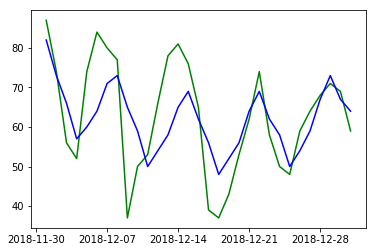

In [233]:
plot.plot_date(test_pred_df['stay_dt'],test_pred_df['rooms'],'green')
# green - Original number of bookings

#plot.plot_date(test_pred_df['stay_dt'],test_pred_df['predict'],'red')
#red - Number of bookings predicted

plot.plot_date(test_pred_df['stay_dt'],test_pred_df['avg_prediction'],'blue')
#blue - Number of bookings predicted
plot.show()


In [234]:
from sklearn import metrics
print(np.sqrt(metrics.mean_squared_error(test_pred_df['rooms'], test_pred_df['avg_prediction'])))

10.2752442872


In [236]:
test_pred_df

,stay_dt,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,week_day,day,weekend,rooms,predict,avg_prediction
0,2018-12-01,0,0,0,0,0,0,0,0,0,0,0,1,5.0,1.0,1.0,87.0,83.646805,82
1,2018-12-02,0,0,0,0,0,0,0,0,0,0,0,1,6.0,2.0,1.0,74.0,82.253009,73
2,2018-12-03,0,0,0,0,0,0,0,0,0,0,0,1,0.0,3.0,0.0,56.0,55.618038,66
3,2018-12-04,0,0,0,0,0,0,0,0,0,0,0,1,1.0,4.0,0.0,52.0,61.482469,57
4,2018-12-05,0,0,0,0,0,0,0,0,0,0,0,1,2.0,5.0,0.0,74.0,54.775378,60
5,2018-12-06,0,0,0,0,0,0,0,0,0,0,0,1,3.0,6.0,0.0,84.0,65.998081,64
6,2018-12-07,0,0,0,0,0,0,0,0,0,0,0,1,4.0,7.0,1.0,80.0,72.517729,71
7,2018-12-08,0,0,0,0,0,0,0,0,0,0,0,1,5.0,8.0,1.0,77.0,74.512544,73
8,2018-12-09,0,0,0,0,0,0,0,0,0,0,0,1,6.0,9.0,1.0,37.0,74.347493,65
9,2018-12-10,0,0,0,0,0,0,0,0,0,0,0,1,0.0,10.0,0.0,50.0,48.680411,59


In [ ]:
# -----Without Normalization ----
#=================================
# 1st degree mse = 12.1676682343 
# 2nd degree mse = 12.161907418
# 3rd degree mse = 14.565
# 4th degree mse = 15.938
# 5th degree mse = 20.222
# 6th degree mse = 62.015

In [ ]:
# -----Using Normalization----
#=================================
# 1st degree mse = 12.5
# 2nd degree mse = 10.89
# 3rd degree mse = 12.62
# 4th degree mse = 13.2
# 5th degree mse = 15.07
# 6th degree mse = 40.025

In [ ]:
df = df_booking_data.loc[:,:].copy()
month = 12
prev_year = 2018

In [ ]:
#def yearly_change_factor(df,month,prev_yr):
    
for i in df.index:
    stay_date = df.get_value(i,'stay_dt')
    mm = stay_date.month
    yy = stay_date.year
    df.set_value(i,'month',mm)
    df.set_value(i,'year',yy)
df = df.groupby(['year','month'],as_index = False)[['rooms']].sum()
df = df[(df.month == month) & (df.year <= prev_year)]


In [ ]:
df

In [ ]:
idx = df.index
#     increment = 0
#     j=idx[0]
#     k=idx[1]
l = idx.size
if (l <= 1):
    factor = 0
else:
    j = idx[l-1]
    k = idx[l-2]

    factor = (df.get_value(j,'rooms'))/(df.get_value(k,'rooms'))
if((factor > 1.5) and (factor < 2)):
    factor = factor * (1/5)
elif (factor > 2):
    factor = factor / 10
     
increment = factor * (df.get_value(j,'rooms'))

In [ ]:
increment